# The Stanford Bunny with PyVista

You have to install the PyVista package to run this example! If you don't have it installed, run the following command in your terminal:

```
pip install pyvista
```

In [12]:
from axisvm.com.client import start_AxisVM
axvm = start_AxisVM(visible=True, daemon=True)

Read the model file from PyVista and get the coordinate and the topology array.

In [13]:
import numpy as np
from pyvista import examples

bunny = examples.download_bunny_coarse().cast_to_unstructured_grid()
coords = bunny.points
coords *= 100  # scale up the geometry a little bit
topo = np.array(bunny.cells_dict[5], dtype=int)

Get the unique edges of the triangulation. This code block uses the PolyMesh library, which is a direct dependency of PyAxisVM. The following block is reusable for any kind of triangulation.

In [14]:
from polymesh.utils.tri import edges_tri
from polymesh.utils.topology import unique_topo_data

edges, edgeIDs = unique_topo_data(edges_tri(topo))
edges += 1
edgeIDs += 1

Create a new model.

In [15]:
modelId = axvm.Models.New()
axm = axvm.Models.Item[modelId]
axm.Settings.EditingTolerance = -1
wdir = ""

Add nodes

In [16]:
from axisvm.com.tlb import RPoint3d

foo = lambda x : RPoint3d(x=x[0], y=x[1], z=x[2])
axm.BeginUpdate()
axm.Nodes.BulkAdd(list(map(foo, coords)))
axm.EndUpdate()

0

Add edges

In [17]:
from axisvm.com.tlb import lgtStraightLine, RLineData

def gen_line(edge):
    return RLineData(
        NodeId1 = edge[0],
        NodeId2 = edge[1],
        GeomType = lgtStraightLine
    )
axm.BeginUpdate()
axm.Lines.BulkAdd(list(map(gen_line, edges)))
axm.EndUpdate()

0

In [18]:
from axisvm.com.tlb import vTop

axm.View = vTop
axm.FitInView();

In [19]:
from axisvm.com.tlb import ndcEuroCode

axm.Settings.NationalDesignCode = ndcEuroCode
matId = axm.Materials.AddFromCatalog(ndcEuroCode, "C16/20")

In [20]:
from axisvm.com.tlb import RSurfaceAttr, lnlTensionAndCompression, \
    RResistancesXYZ, schLinear, stShell, RElasticFoundationXYZ, \
    RNonLinearityXYZ, RSurface

SurfaceAttr = RSurfaceAttr(
    Thickness=0.1,
    SurfaceType=stShell,
    RefZId=0,
    RefXId=0,
    MaterialId=matId,
    ElasticFoundation=RElasticFoundationXYZ(0, 0, 0),
    NonLinearity=RNonLinearityXYZ(lnlTensionAndCompression,
                                  lnlTensionAndCompression,
                                  lnlTensionAndCompression),
    Resistance=RResistancesXYZ(0, 0, 0),
    Charactersitics=schLinear)

def gen_surface(edges):
    return RSurface(
        N=3,
        LineIndex1 = edges[0],
        LineIndex2 = edges[1],
        LineIndex3 = edges[2],
        Attr = SurfaceAttr,
        DomainIndex = 0
    )
axm.BeginUpdate()
axm.Surfaces.BulkAdd(list(map(gen_surface, edgeIDs)))
axm.EndUpdate()

0

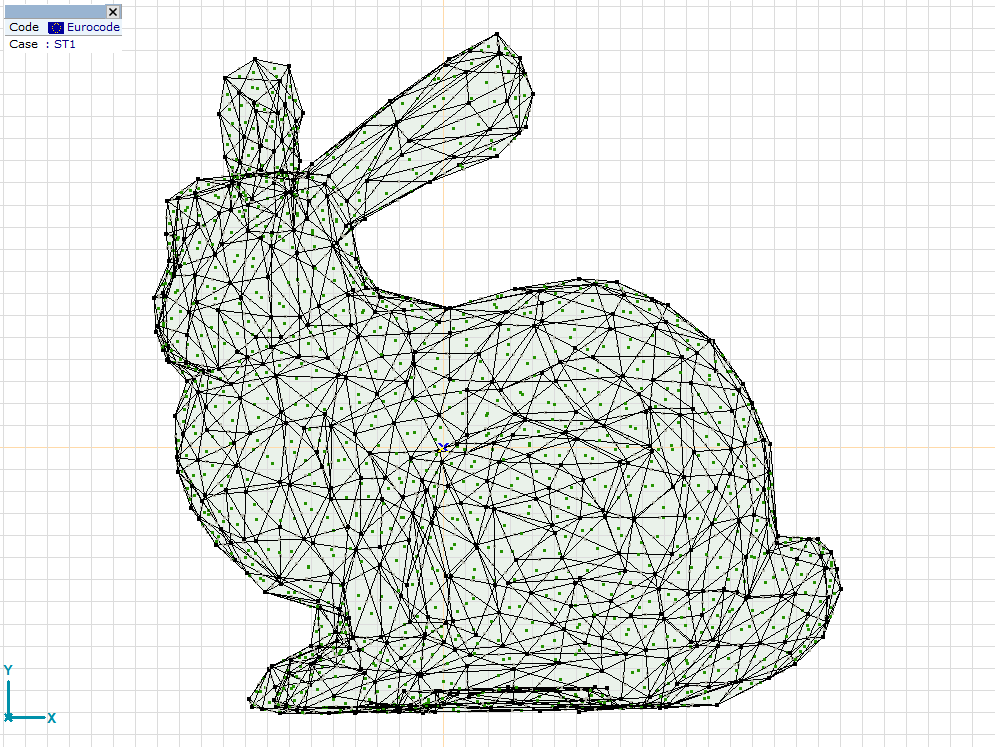

In [21]:
from axisvm.com.tlb import vTop, mftGeometry

axvm.BringToFront()
axm.View = vTop
axvm.MainFormTab = mftGeometry
axm.FitInView()
axm.Windows[1].screenshot()

In [22]:
axvm.Quit()